# Analyzing SMITE Match Data for Matchup Predictor

Kevin Chen, Joel Metcalf

## Outline
1. <b> Introduction </b>
    1. Background
    2. Libraries Used

2. <b>Data Collection </b>
    1. Data Source
    2. About the Data
    3. Data Cleaning

3. <b>Data Analysis and Visualization </b>
    1. Pick rates and Win rates between Ranks
    2. Average Win rates and Counter matchup
    3. Kills and Wins

4. <b>Model </b>

5. <b>Conclusion</b>

## 1. Introduction
We love the video game SMITE. We are on the official Esports team for SMTIE here at UMD, and are currently in the playoffs of the college SMITE tournament. Becuase of our connection to the game, we thought it'd be really cool to analyze and do a project on the game that we enjoy playing and competing in.
For this project, we will analyze Ranked Conquest matches, perform exploratory data analysis, and try to develop a model to determine which team in expected to win given the matchup. Most models for determining which team will win are during a game, with full knowledge of the objectives being taken, gold, and experience differences. However, we will analyze and determine if it's possible to develop a model to predict which team will win before the game starts, purely based off of the drafts (god selections) of both teams.

### 1.a Background

SMITE is a Multiplayer Online Battleground Arena (MOBA) game similar to more popular games of the same genre, such as DOTA 2 and League of Legends. SMITE has a total of 117 playable characters and has a 5v5 mode called Conquest, which is the main mode used for tournament and pro matches. Ranked Conquest is a mode for competitive play, while normal Conquest is more tailored towards casual players looking for some light fun. Ranked Conquest splits players into different ranks: Bronze, Silver, Gold, Platinum, Diamond, Masters, and Grandmasters. For more information about the Rank system in SMITE, here's a link that discusses the ranked system in further detail: https://smite.fandom.com/wiki/Ranked. Our analysis will be entirely focused on ranked conquest matches, because they are the most competitive, and will therefore give more objective data about how different gods perform.
<br><br>
### 1.b Libraries Used
The code below lists the libraries used to run the code in the rest of the notebook


In [1]:
import random
import sqlite3 
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import defaultdict

## 2. Data Collection
In this section, we will discuss the data that will be used for analysis and model development. We will perform collection, and cleaning of the data.
### 2.a Data Source
The source of our data is from the SMITE API. To use the SMITE API, you must first request access from HiRez and then you will be given access by an employee. In our case, we also had to apply to raise our api access limit to 100k requests per day as the default is only 7.5k api requests. From there, the documentations to access the API can be found in the document https://docs.google.com/document/d/1OFS-3ocSx-1Rvg4afAnEHlT3917MAK_6eJTR6rzr-BM/edit#. If you just want to use our data, it is right here: https://www.dropbox.com/s/dt1si8vktcq6aoo/smitedata.db?dl=0<br>

### 2.b Collecting the Data
In order to collect the data, you should make a sqlite database to contain the data you want to collect. They way we store the data is to first use one table to save the JSON itself (this takes a lot of space but has allowed us to adjust what we take from the data whenever we want). We then process the JSON and place the relevant data into other tables. Our database structure essentially looks like this:
```
CREATE TABLE matchids(
    matchId INTEGER PRIMARY KEY,
    json TEXT
)
CREATE TABLE matches (
    matchId INTEGER PRIMARY KEY,
    region TEXT NOT NULL,
    matchLength INTEGER NOT NULL,
    winningGods TEXT NOT NULL,
    losingGods TEXT NOT NULL,
    averageRank REAL NOT NULL,
    winnerStructureDamage INTEGER NOT NULL,
    loserStructureDamage INTEGER NOT NULL,
    goldDisparity INTEGER NOT NULL
)
CREATE TABLE playerentry (
    matchId INTEGER NOT NULL,
    god TEXT NOT NULL,
    kills INTEGER NOT NULL,
    deaths INTEGER NOT NULL,
    assists INTEGER NOT NULL,
    accountLevel INTEGER NOT NULL,
    winner INTEGER NOT NULL,
    playerDamage INTEGER NOT NULL
)
```
matchids is the staging area where the json is stored before processing. From there, we check which matchIds have valid (non-null) json but still have no entry in the matches table. We check for null because sometimes the server will return no json to an api request in a small percentage of matches. We believe this is okay though, as the match data missing is random based on the health of SMITE's servers, and therefore we expect that it is uncorrelated with any data we care about.

Each matchid generates an entry in the matches table, where we save the region the match was played, the length of the match in seconds, the winning gods as a csv string, the losing gods similarly, the average elo of the involved players, the total structure damage of each team (we collect this as data to show how close the match may be, as structure damage is how much damage you have done to your opponent's base, something you do when you're winning), and gold disparity (another metric of a close game).

For each matchid, 10 associated playerentry records are created with the matchId field pointing back to the associated match. The player data includes their god, kills, deaths, assists, account level (a potential experience metric), whether or not they won (represented as a 1 or 0), and how much damage they did (this is an imperfect measure of sucess in the game, as tank/support characters can still contribute heavily to their team, yet lose).

In order to interface with the SMITE api, you need to generate a session that lasts 15 minutes. This session requires a signature that is an md5 hash of your credentials, whatever api you are calling, and the current utc timestamp. Here is our code that we call to do it.

smiteapi.py
```python
import hashlib
import requests
import datetime
import sqlite3

devId = "4133"
authKey = "redacted"
urlBase = 'https://api.smitegame.com/smiteapi.svc'
responseType = 'json'
connection = sqlite3.connect('smitedata.db')

def createSignature(method):
    time = datetime.datetime.utcnow()
    timeStamp = time.strftime("%Y%m%d%H%M%S")
    signature = devId + method + authKey + timeStamp
    signatureHash = hashlib.md5(signature.encode()).hexdigest()
    return signatureHash, timeStamp


def createSession():
    method = 'createsession'
    signatureHash, timeStamp = createSignature(method)
    url = f'{urlBase}/{method}Json/{devId}/{signatureHash}/{timeStamp}'
    response = requests.get(url)
    if response.status_code != 200:
        print(url)
        print(f"Session Creation Failed: {response.status_code}")
        exit(1)
    elif response.json()["ret_msg"] != "Approved":
        print(response.json())
        print("Session Creation Denied")
        exit(2)
    sessionId = response.json()["session_id"]
    with open('session_id.txt', 'w') as f:
        f.writelines(f'{sessionId}\n{timeStamp}')
    return sessionId

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
```

In order to get all the necessary data, you should first request all the matchids from the ranked conquest queue, from a start date to an end date, for each hour between 0 and 23. We did that here:

get_match_ids.py
```python
import datetime
from json.decoder import JSONDecodeError
import requests
from smite_api import createSession, createSignature, devId, urlBase, responseType, connection

if __name__ == "__main__":
    with open('session_id.txt') as f:
        [sessionId, oldTime] = f.read().splitlines()
        oldDatetime = datetime.datetime.strptime(oldTime, "%Y%m%d%H%M%S")
        delta = datetime.datetime.utcnow() - oldDatetime
        if delta.days != 0 or delta.seconds / 60 >= 15:
            print("generating new session token")
            sessionId = createSession()
    
    method = 'getmatchidsbyqueue'
    rankedConquestQueueID = "451"
    # from 11/16 to 12/9 has been tried so far
    days = ['1116','1117','1118','1119','1120','1121','1122','1123']
    signatureHash, timeStamp = createSignature(method)
    with open('match_ids.txt', 'w') as f:
        f.write('')
    for day in days:
        for hour in range(0,24):
            print(f'looking for matches on {day} {hour}')
            url = f'{urlBase}/{method}{responseType}/{devId}/{signatureHash}/{sessionId}/{timeStamp}/{rankedConquestQueueID}/2021{day}/{hour}'
            response = requests.get(url)
            try:
                matches = response.json()
            except JSONDecodeError:
                print(response.status_code)
                continue
            with open('match_ids.txt', 'a') as f:
                for match in matches:
                    f.write(match['Match'] + '\n')
                    
```
Next, you should quickly try to request the match data from the SMITE server. We use python's extremely useful aiohttp package to take a multithreaded approach to getting the data. This drastically sped up our data download from getting it in series. You should set your script to take any matchid that is in match_ids.txt but has no entry in the matchids table and request its data from the server.

process_match_ids_async.py
```python
import datetime
from json.decoder import JSONDecodeError
import sqlite3
import requests
from smite_api import createSession, createSignature, devId, urlBase, responseType, connection, printProgressBar
import logging
import timeit
import aiohttp
import asyncio
import time
import json

cur = connection.cursor()

def addJsonToMatchids(data):
    try :
        matchId = int(data[0]['Match'])
        sql = '''
            UPDATE matchids
            SET json = ?
            WHERE matchid = ?
        '''
        cur.execute(sql, (json.dumps(data), matchId))
        connection.commit()
    except IndexError:
        logging.error(data)
    except TypeError:
        logging.error(data)

async def getMatchData(session, matchId):
    method = 'getmatchdetails'
    signatureHash, timeStamp = createSignature(method)
    url = f'{urlBase}/{method}{responseType}/{devId}/{signatureHash}/{sessionId}/{timeStamp}/{matchId}'
    
    async with session.get(url) as response:
        json = None
        try:
            json = await response.json()
            
        except JSONDecodeError:
            logging.error(f'{matchId} {response.status_code}')         
        except Exception:
            logging.error(f'{matchId} {response}')
        getMatchData.count += 1
        printProgressBar(getMatchData.count, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        return json
getMatchData.count = 0

async def main(matches):    
    async with aiohttp.ClientSession() as session:
        tasks = []

        for matchId in matches:
            tasks.append(asyncio.ensure_future(getMatchData(session, matchId)))
        
        matches = await asyncio.gather(*tasks)
        for match in matches:
            addJsonToMatchids(match)



if __name__ == "__main__":
    start = timeit.default_timer()
    # check if saved session_Id is too old
    with open('session_id.txt') as f:
        [sessionId, oldTime] = f.read().splitlines()
        oldDatetime = datetime.datetime.strptime(oldTime, "%Y%m%d%H%M%S")
        delta = datetime.datetime.utcnow() - oldDatetime
        if delta.days != 0 or delta.seconds / 60 >= 15:
            print("generating new session token")
            sessionId = createSession()

    # load all staged match ids
    sql = '''
        SELECT matchid 
        FROM matchids
        WHERE json IS NULL
    '''

    matches = cur.execute(sql).fetchall()
    matches = [x[0] for x in matches]

    l = len(matches)
    
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    batches = 1000
    count = 0
    while len(matches) > 0 and count < batches:
        batch = matches[0:200]
        matches = matches[200:]
        asyncio.run(main(batch))
        count += 1
        print(f'batch {count} complete')
        time.sleep(1)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  
```

From here you should have the json already in your sqlite database. The next step is to process it to get all the data you are interested in. We explain what data we are interested in with the database schema, and so we simply use python's json reading library to populate our tables.

process_json_data.py
```python
from smite_api import connection, printProgressBar
import logging
import sqlite3
import json

def processMatchJson(players):
    try :
        matchId = int(players[0]['Match'])
        region = players[0]['Region']
        matchLength = players[0]['Match_Duration']
        winningGods = ''
        losingGods = ''
        averageRank = 0
        winnerStructureDamage = 0
        loserStructureDamage = 0
        goldDisparity = 0

        cur = connection.cursor()
        
        sql = '''INSERT OR IGNORE INTO playerentry(matchId,god,kills,deaths,assists,accountLevel,winner,playerDamage)
        VALUES(?,?,?,?,?,?,?,?)'''
        try:          
            for player in players:
                averageRank += player['Rank_Stat_Conquest']
                if player['Win_Status'] == "Winner":
                    winningGods += player['Reference_Name'] + ','
                    winnerStructureDamage += int(player['Structure_Damage'])
                    goldDisparity += int(player['Gold_Earned'])
                    winner = 1
                else:
                    losingGods += player['Reference_Name'] + ','
                    loserStructureDamage += int(player['Structure_Damage'])
                    goldDisparity -= int(player['Gold_Earned'])
                    winner = 0
                god = player['Reference_Name']
                kills = int(player['Kills_Player'])
                deaths = int(player['Deaths'])
                assists = int(player['Assists'])
                accountLevel = int(player['Account_Level'])
                playerDamage = int(player['Damage_Player'])
                cur.execute(sql, (matchId, god, kills, deaths, assists, accountLevel, winner, playerDamage))
            
            sql = '''INSERT INTO matches(matchId,region,matchLength,winningGods,losingGods,averageRank,winnerStructureDamage,loserStructureDamage,goldDisparity)
            VALUES(?,?,?,?,?,?,?,?,?)'''
            cur.execute(sql, (matchId, region, matchLength, winningGods, losingGods, averageRank, winnerStructureDamage, loserStructureDamage, goldDisparity))
            connection.commit()
        except sqlite3.IntegrityError:
            print(f'duplicate matchid {matchId}')
    except IndexError:
        logging.error(players)
    except TypeError:
        logging.error(players)


sql = '''
    SELECT json
    FROM matchids
    WHERE json IS NOT NULL
    AND NOT EXISTS(select 1 from matches where matches.matchid = matchids.matchid)
    '''

cur = connection.cursor()
data = cur.execute(sql).fetchall()
l = len(data)

printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
for i, entry in enumerate(data):
    if (i % 100) == 0:
        printProgressBar(i, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    processMatchJson(json.loads(entry[0]))
```

### 2.c Data Cleaning
Now that you have collected data from the SMITE API, you should take out any data that is malformed or not useful. As mentioned before, some of the api requests will return an empty json "[]". In this case we just threw that out. Also, some games with server issues wouldn't load properly, leading to fewer than 10 players in a match. These matches also had meaningless data, as they didn't really start. So we threw those out too. In our 69k match dataset, we had about 10 of these matches.

This lets you see the matches with the fewest players
```
SELECT matchid, COUNT(matchid)
FROM playerentry
GROUP BY matchid
ORDER BY COUNT(matchid) ASC LIMIT 20;
```
This is how we deleted ours
```
DELETE FROM matches
WHERE matchId in (
1202788199,
1205407494,
1206706393,
1206706410,
1204078348,
1206705169,
1206705171,
1206705176,
1206729702,
1206729709
)
```
Now, you can load your data into pandas.
Below is a simple example of the first 5 rows and what they should look like. 

In [2]:
# establish connection with database with SMITE data
sqlite_file = 'smitedata.db'
conn = sqlite3.connect(sqlite_file)

In [3]:
# get all rows from relation, "matches", and convert to a DataFrame
query = """SELECT * FROM matches"""
data = pd.read_sql(query, conn)
data

,matchId,region,matchLength,winningGods,losingGods,averageRank,winnerStructureDamage,loserStructureDamage,goldDisparity
0,1202691204,EU,1617,"Apollo,Tyr,Medusa,Tiamat,Cabrakan,","Susano,Terra,Olorun,Ullr,Xing Tian,",16457.079220,9763,275,15926
1,1202691205,EU,1804,"Charybdis,Ravana,Agni,Sylvanus,Khepri,","Sol,Tsukuyomi,Izanami,Olorun,Athena,",11212.444448,14442,3793,13166
2,1202691206,Brazil,1207,"Charybdis,Janus,Nike,Chang'e,Athena,","Loki,Zeus,Achilles,Poseidon,Hachiman,",21361.318090,7725,1062,16310
3,1202691207,Brazil,1101,"Hun Batz,Ullr,Achilles,Sol,Ares,","Anubis,Thanatos,Nike,Hou Yi,Kuzenbo,",15762.512720,5656,921,7859
4,1202691208,Brazil,2136,"Loki,Agni,Erlang Shen,Hou Yi,Kuzenbo,","Mercury,Neith,Ares,He Bo,Sun Wukong,",15244.097690,16217,471,15531
...,...,...,...,...,...,...,...,...,...
69149,1208475349,NA,2226,"Scylla,Kali,Hou Yi,Nike,Cabrakan,","Loki,Chiron,Vamana,Chang'e,Khepri,",13954.009530,7585,13784,-305
69150,1208475350,NA,1720,"Hun Batz,Rama,Morgan Le Fay,Cerberus,Serqet,","Fenrir,Odin,Sol,Baba Yaga,Cliodhna,",21551.300890,10141,4510,15690
69151,1208475351,NA,660,"Sol,Gilgamesh,Artio,Nike,Ah Muzen Cab,","Apollo,Pele,Ganesha,Chang'e,Neith,",10608.985026,3044,111,6103
69152,1208475354,NA,1392,"Loki,Sol,Mulan,Hou Yi,Khepri,","Medusa,Erlang Shen,Tsukuyomi,Tiamat,Sylvanus,",20585.748220,8403,753,7576


In [4]:
# get all player data 
query = """SELECT * FROM playerentry"""
playerdata = pd.read_sql(query,conn)
playerdata

,matchId,god,kills,deaths,assists,accountLevel,winner,playerDamage
0,1202691204,Apollo,12,4,4,151,1,26144
1,1202691204,Tyr,5,0,3,125,1,18002
2,1202691204,Medusa,4,3,4,160,1,20400
3,1202691204,Tiamat,5,4,7,160,1,21541
4,1202691204,Cabrakan,1,4,12,149,1,11203
...,...,...,...,...,...,...,...,...
691535,1208475355,Freya,5,11,1,79,0,14213
691536,1208475355,Thor,3,5,3,160,0,10892
691537,1208475355,Scylla,1,6,5,143,0,8521
691538,1208475355,Charybdis,0,6,4,160,0,5480


Looking at the sizes of these two tables, it makes sense that there are exactly 10 times as many player entries as there are matches. This is because there are 10 players per match.

Now that we have filtered out the raw data for valid Ranked matches, we can now start cleaning the data.
<br><br>
In SMITE, characters are sometimes reworked, where the character gets new abilities and is taken out of competitive play, such as Ranked Conquest, for a short period of time. As of December 13, 2021, the character Bastet, was reworked, and has been banned from Ranked Conquest for a few weeks. The data we have collected includes matches that occurred before and after the rework. Our data collection didn't end until slightly after Bastet was allowed in ranked and so we have a couple hundred games that include her. Because of this tiny volume of games, we will remove any match that includes Bastet. However, for future reference, you can remove matches with any characters that you don't want to consider for your analysis or model, as shown below.
<br>
Also, we need to modify the averageRank attribute. Due to a mistake in process_json_data.py, even though it's called averageRank, it's actually the sum of all ranks of the players. Therefore, to get the true averageRank we must divide by 10, since there are 10 players in a match.
<br>
Finally, we must check to make sure averageRank has a value of at least zero for all matches. We are not sure why the value is rarely negative, could be server issues, or how errors in how values are recorded for matches. 

In [5]:
# collect list of indices that contains the characters/gods we want to remove
rmv_gods = ['Bastet']
rmv_indx = []
rmv_matchid = []
 
for i, row in data.iterrows():
    # check if any characters we want to remove are in either teams using the "any" function
    if any(god in rmv_gods for god in row.winningGods.split(',')) \
        or any(god in rmv_gods for god in row.losingGods.split(',')):
        rmv_indx.append(i)
        rmv_matchid.append(row.matchId)
    # check if match length is less than or equal to 10 minutes
    elif row['matchLength'] <= 600:
        rmv_indx.append(i)
        rmv_matchid.append(row.matchId)
    # sanity check to make sure average ranks in dataset are all non-negative 
    elif row.averageRank < 0:
        rmv_indx.append(i)
        rmv_matchid.append(row.matchId)
        
# remove rows that contain the characters we want to remove
data.drop(data[data['matchId'].isin(rmv_matchid)].index, inplace = True)
playerdata.drop(playerdata[playerdata['matchId'].isin(rmv_matchid)].index, inplace = True)

# properly set the correct value for averageRank attribute
data['averageRank'] = data['averageRank']/10

As discussed above, Ranked Conquest has multiple ranks, and a given numerical value assigned to each player to determine which rank the player is in, called Match-Making Rank (MMR). According to SMITE, a MMR of [0,640) is Bronze,[640,1205) is Silver, [1205,1525) is Gold, [1525,2000) is Platinum, [2000,2500) is Diamond, [2500,3500) is Masters, and the top 50 players in Masters are in GrandMasters. For simplicity, we can add a new column showing what rank the match is in by checking the 'averageRank' attribute for each match.
<br>

In [6]:
# create bins for each rank
bins = [0,640,1205,1525,2000,2500,3500]
# add new column, assigning an interval for each match
data['rank_interval'] = pd.cut(data['averageRank'],bins,right=False) 
# create mapping between the interval and actual rank title
ranks = {'[0, 640)':'Bronze',
         '[640, 1205)':'Silver',
         '[1205, 1525)':'Gold',
         '[1525, 2000)':'Platinum',
         '[2000, 2500)':'Diamond',
         '[2500, 3500)':'Masters'}
# assign each row the correct rank for the match
data['rank'] = [ranks[str(row.rank_interval)] for i,row in data.iterrows()]
data

,matchId,region,matchLength,winningGods,losingGods,averageRank,winnerStructureDamage,loserStructureDamage,goldDisparity,rank_interval,rank
0,1202691204,EU,1617,"Apollo,Tyr,Medusa,Tiamat,Cabrakan,","Susano,Terra,Olorun,Ullr,Xing Tian,",1645.707922,9763,275,15926,"[1525, 2000)",Platinum
1,1202691205,EU,1804,"Charybdis,Ravana,Agni,Sylvanus,Khepri,","Sol,Tsukuyomi,Izanami,Olorun,Athena,",1121.244445,14442,3793,13166,"[640, 1205)",Silver
2,1202691206,Brazil,1207,"Charybdis,Janus,Nike,Chang'e,Athena,","Loki,Zeus,Achilles,Poseidon,Hachiman,",2136.131809,7725,1062,16310,"[2000, 2500)",Diamond
3,1202691207,Brazil,1101,"Hun Batz,Ullr,Achilles,Sol,Ares,","Anubis,Thanatos,Nike,Hou Yi,Kuzenbo,",1576.251272,5656,921,7859,"[1525, 2000)",Platinum
4,1202691208,Brazil,2136,"Loki,Agni,Erlang Shen,Hou Yi,Kuzenbo,","Mercury,Neith,Ares,He Bo,Sun Wukong,",1524.409769,16217,471,15531,"[1205, 1525)",Gold
...,...,...,...,...,...,...,...,...,...,...,...
69149,1208475349,NA,2226,"Scylla,Kali,Hou Yi,Nike,Cabrakan,","Loki,Chiron,Vamana,Chang'e,Khepri,",1395.400953,7585,13784,-305,"[1205, 1525)",Gold
69150,1208475350,NA,1720,"Hun Batz,Rama,Morgan Le Fay,Cerberus,Serqet,","Fenrir,Odin,Sol,Baba Yaga,Cliodhna,",2155.130089,10141,4510,15690,"[2000, 2500)",Diamond
69151,1208475351,NA,660,"Sol,Gilgamesh,Artio,Nike,Ah Muzen Cab,","Apollo,Pele,Ganesha,Chang'e,Neith,",1060.898503,3044,111,6103,"[640, 1205)",Silver
69152,1208475354,NA,1392,"Loki,Sol,Mulan,Hou Yi,Khepri,","Medusa,Erlang Shen,Tsukuyomi,Tiamat,Sylvanus,",2058.574822,8403,753,7576,"[2000, 2500)",Diamond


## 3. Data Analysis and Visualization
Now that we have cleaned the data, we now analyze the data to check the basic assumptions we will make for our model. You can also do various interesting types of data analysis. There are a ton of ways to analyse and take away cool things from this data, and we encourage you to try something new. **We tried out three different ways of looking at different aspects of this data that could be good guides.**

### 3.1 Pick Rates and Ranks
Something we can explore is the amount of times each character is played in the dataset. We know that some characters are just better than others, and will most likely be played more often. 

Lets start by creating a set for all played characters in the dataset.

In [7]:
# get list of all characters from all matches in dataset, from 2nd table
gods = {g for g in playerdata['god']}
print('List of all unique playable gods in dataset: \n' + str(gods))

List of all unique playable gods in dataset: 
{'Chiron', 'Hel', 'Artio', 'Nike', 'Thoth', 'Kumbhakarna', 'Ganesha', 'Bacchus', 'Set', 'Medusa', 'Agni', 'Serqet', 'Arachne', 'Athena', 'Cernunnos', 'Thanatos', 'Tyr', 'Da Ji', 'Cliodhna', 'Eset', 'Xing Tian', 'Ullr', 'Bellona', 'Odin', 'Kuzenbo', 'Thor', 'Xbalanque', 'Sylvanus', 'Hera', 'Kali', 'Artemis', 'Cupid', 'Jormungandr', 'Anhur', 'Apollo', 'Ah Puch', 'Baba Yaga', 'Ao Kuang', 'Cthulhu', 'Heimdallr', 'Kukulkan', 'Pele', 'Erlang Shen', 'Aphrodite', 'Chronos', 'Mercury', 'Ra', 'Raijin', 'Osiris', 'Gilgamesh', 'Merlin', 'Hades', 'Ne Zha', 'Hercules', 'Ravana', 'Sol', 'Cerberus', 'Nu Wa', 'Zhong Kui', 'Horus', 'Hun Batz', 'Scylla', 'Morgan Le Fay', 'Rama', 'Sobek', 'Fafnir', 'Skadi', 'Vulcan', 'Ah Muzen Cab', 'Nemesis', 'Persephone', 'Chernobog', 'Poseidon', 'Khepri', 'Hachiman', 'Geb', 'The Morrigan', 'Neith', 'Yemoja', 'Camazotz', 'Jing Wei', 'Cu Chulainn', 'Tiamat', 'Ymir', 'King Arthur', 'Discordia', 'Izanami', 'Vamana', 'Bakasura',

In [8]:
played = {god:0 for god in gods}
# iterate through 2nd table, to calculate number of times each god is picked
for i,row in playerdata.iterrows(): played[row.god] += 1
# sort the dict based on number of games
played = {key:val for key, val in sorted(played.items(), key=lambda g: g[1])}
print(played)

{'Ah Puch': 1281, 'He Bo': 1650, 'Bakasura': 1800, 'Chernobog': 1869, 'Amaterasu': 2042, 'Jormungandr': 2063, 'Nox': 2099, 'Vamana': 2141, 'Eset': 2311, 'Freya': 2378, 'Baron Samedi': 2385, 'Baba Yaga': 2426, 'Hel': 2457, 'Raijin': 2530, 'Hades': 2635, 'Horus': 2691, 'Hera': 2753, 'Pele': 3023, 'Ratatoskr': 3053, 'Set': 3081, 'Aphrodite': 3175, 'Discordia': 3295, 'Ao Kuang': 3375, 'Osiris': 3400, 'Jing Wei': 3401, 'Skadi': 3432, 'Serqet': 3476, 'Cernunnos': 3596, "Chang'e": 3602, 'Chronos': 3621, 'Yemoja': 3684, 'Terra': 3702, 'Anubis': 3816, 'Zhong Kui': 3907, 'Kumbhakarna': 3912, 'Persephone': 3962, 'King Arthur': 4037, 'Cabrakan': 4047, 'Da Ji': 4054, 'Fafnir': 4188, 'Ne Zha': 4215, 'The Morrigan': 4496, 'Cthulhu': 4535, 'Arachne': 4553, 'Kuzenbo': 4553, 'Cupid': 4608, 'Hun Batz': 4656, 'Vulcan': 4667, 'Artemis': 4682, 'Mercury': 4696, 'Nu Wa': 4749, 'Susano': 4895, 'Cu Chulainn': 4909, 'Olorun': 4963, 'Thor': 4972, 'Poseidon': 4981, 'Danzaburou': 4996, 'Tyr': 5029, 'Erlang Shen': 5

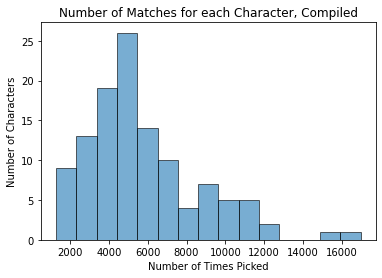

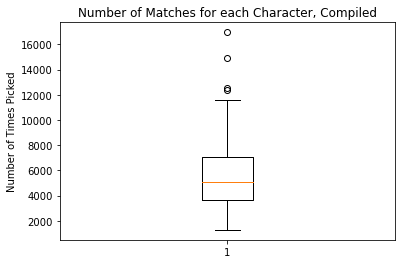

In [9]:
# get list of number of games for each character from above
x = [played[g] for g in played]
fig1,ax1 = plt.subplots()
# generate histogram
ax1.hist(x, bins=15,ec='black',alpha=0.6)
# add title and labels for axes
ax1.set_title('Number of Matches for each Character, Compiled')
ax1.set(xlabel='Number of Times Picked', ylabel='Number of Characters')

# generate a boxplot
fig2,ax2 = plt.subplots()
# generate histogram
ax2.boxplot(x)
# add title and labels for axes
ax2.set_title('Number of Matches for each Character, Compiled')
ax2.set(ylabel='Number of Times Picked')

plt.show()

As shown above, we see that not all characters are played the same amount of times, with some characters played much more often than others. For example, we see that Achilles and Mulan are played at least 15000 times, while all other characters are played in less than 13000 matches, with the character Ah Puch being played the least, with 1326 games. This checks out, as we are on the esports team, and can attest that Achilles and Mulan are known to be the strongest characters in the game at the moment. Also, based on the boxplot, we see that there are outliers, indicating a high pick rate, due to their popularity and strength compared to other characters. 

<br>
Something else we can look at is the distribution of matches between different ranks. We expect that the distribution of matches to be approximately normal between different ranks, because Gold is usually the skill for average players, with Bronze and Masters being on either extremes of extreme high and low skill players.


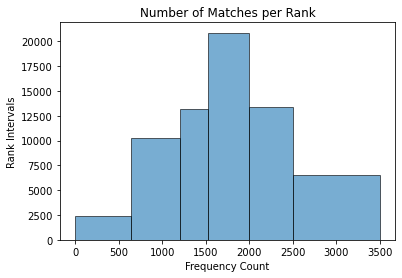

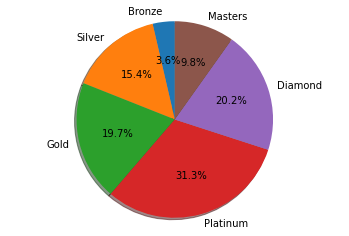

In [10]:
# get list of number of games for each character from above
x = [row.averageRank for i,row in data.iterrows()]
fig1,ax1 = plt.subplots()
# generate histogram, with bars
ax1.hist(x, bins=[0,640,1205,1525,2000,2500,3500],ec='black',alpha=0.6)
# add title and labels for axes
ax1.set_title('Number of Matches per Rank')
ax1.set(xlabel='Frequency Count', ylabel='Rank Intervals')

labels = 'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Masters'
sizes = [len(data[data['rank'] == 'Bronze']), 
         len(data[data['rank'] == 'Silver']), 
         len(data[data['rank'] == 'Gold']), 
         len(data[data['rank'] == 'Platinum']),
        len(data[data['rank'] == 'Diamond']),
        len(data[data['rank'] == 'Masters'])]
explode = (0, 0, 0, 0, 0, 0)

fig2, ax2 = plt.subplots()
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax2.axis('equal')  

plt.show()

As we see in the above graph, the actual width of the intervals are not equal, which is expected, since the intervals for each rank are different, such as Gold having the interval [1205, 1525), which is much smaller than Masters, having an interval of [2500,3500). Also, we see that our assumption is correct, that the matches are approximately distributed between the ranks.

### 3.2 Average Win Rates and Counter matchup
For our model we are trying to see if we can create a model to determine which team is expected to win. Therefore, an idea is to look at the actual win rate of the characters. For example, given 2 teams, calculate the average win rate between the characters for each team, and then look to see if there exists a trend between average win rate and if the team wins. We will calculate the win rate by dividing the number of games won by the character by the number of games the character has participated in.

Lets start by calculating the overall win rate for each god.

In [11]:
# calculate overall win rate for each character
win_rates = {god:[0,0] for god in gods}
# iterate through matches, to get the 2 values we require (number of games won, number of games participated in)
for i,row in playerdata.iterrows():            
    if row.winner == 1:
        win_rates[row.god][0] += 1
    win_rates[row.god][1] += 1
# iterate through dict, and calculate win rate for each god
for k in win_rates: 
    win_rates[k] = win_rates[k][0]/win_rates[k][1] if win_rates[k][1] != 0 else None

print(win_rates)

{'Chiron': 0.5268598542619894, 'Hel': 0.4985754985754986, 'Artio': 0.5084063802270441, 'Nike': 0.5404716379859783, 'Thoth': 0.49973568281938324, 'Kumbhakarna': 0.4532208588957055, 'Ganesha': 0.5028416779431665, 'Bacchus': 0.516969696969697, 'Set': 0.48977604673807207, 'Medusa': 0.5070488721804511, 'Agni': 0.5227092685503036, 'Serqet': 0.4502301495972382, 'Arachne': 0.5317373160553481, 'Athena': 0.4965362474387745, 'Cernunnos': 0.5097330367074527, 'Thanatos': 0.4990119506916345, 'Tyr': 0.4559554583416186, 'Da Ji': 0.4753330044400592, 'Cliodhna': 0.522189349112426, 'Eset': 0.5590653396797923, 'Xing Tian': 0.4862642169728784, 'Ullr': 0.4671598973274951, 'Bellona': 0.5038447455144636, 'Odin': 0.526813880126183, 'Kuzenbo': 0.45837909070942234, 'Thor': 0.4442880128720837, 'Xbalanque': 0.5443118536197296, 'Sylvanus': 0.48303762916747905, 'Hera': 0.5027243007628042, 'Kali': 0.5491432266408018, 'Artemis': 0.5192225544639043, 'Cupid': 0.5160590277777778, 'Jormungandr': 0.46146388754241396, 'Anhu

In [12]:
# add new column to data, to calculate average win rate for winning and losing team
winning_win_rate = []
losing_win_rate = []
# iterate through all matches
for i,row in data.iterrows():
    match_id = row.matchId
    winner_side = 0
    loser_side = 0
    
    # lets take the average winrate for all gods on each team
    for god in row.winningGods.split(',')[:-1]:
        winner_side += win_rates[god]
    for god in row.losingGods.split(',')[:-1]:
        loser_side += win_rates[god]  
        
    winning_win_rate.append(winner_side/5)
    losing_win_rate.append(loser_side/5)
    
# add columns to data DataFrame 
data['winning_win_rate'] = winning_win_rate
data['losing_win_rate'] = losing_win_rate

data

,matchId,region,matchLength,winningGods,losingGods,averageRank,winnerStructureDamage,loserStructureDamage,goldDisparity,rank_interval,rank,winning_win_rate,losing_win_rate
0,1202691204,EU,1617,"Apollo,Tyr,Medusa,Tiamat,Cabrakan,","Susano,Terra,Olorun,Ullr,Xing Tian,",1645.707922,9763,275,15926,"[1525, 2000)",Platinum,0.484474,0.497682
1,1202691205,EU,1804,"Charybdis,Ravana,Agni,Sylvanus,Khepri,","Sol,Tsukuyomi,Izanami,Olorun,Athena,",1121.244445,14442,3793,13166,"[640, 1205)",Silver,0.495205,0.529717
2,1202691206,Brazil,1207,"Charybdis,Janus,Nike,Chang'e,Athena,","Loki,Zeus,Achilles,Poseidon,Hachiman,",2136.131809,7725,1062,16310,"[2000, 2500)",Diamond,0.485695,0.505884
3,1202691207,Brazil,1101,"Hun Batz,Ullr,Achilles,Sol,Ares,","Anubis,Thanatos,Nike,Hou Yi,Kuzenbo,",1576.251272,5656,921,7859,"[1525, 2000)",Platinum,0.500717,0.501504
4,1202691208,Brazil,2136,"Loki,Agni,Erlang Shen,Hou Yi,Kuzenbo,","Mercury,Neith,Ares,He Bo,Sun Wukong,",1524.409769,16217,471,15531,"[1205, 1525)",Gold,0.499410,0.492150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69149,1208475349,NA,2226,"Scylla,Kali,Hou Yi,Nike,Cabrakan,","Loki,Chiron,Vamana,Chang'e,Khepri,",1395.400953,7585,13784,-305,"[1205, 1525)",Gold,0.518207,0.521339
69150,1208475350,NA,1720,"Hun Batz,Rama,Morgan Le Fay,Cerberus,Serqet,","Fenrir,Odin,Sol,Baba Yaga,Cliodhna,",2155.130089,10141,4510,15690,"[2000, 2500)",Diamond,0.472304,0.513577
69151,1208475351,NA,660,"Sol,Gilgamesh,Artio,Nike,Ah Muzen Cab,","Apollo,Pele,Ganesha,Chang'e,Neith,",1060.898503,3044,111,6103,"[640, 1205)",Silver,0.532543,0.499065
69152,1208475354,NA,1392,"Loki,Sol,Mulan,Hou Yi,Khepri,","Medusa,Erlang Shen,Tsukuyomi,Tiamat,Sylvanus,",2058.574822,8403,753,7576,"[2000, 2500)",Diamond,0.525656,0.488489


In [13]:
# check out the average winrates for winning team and losing team
print('Average winrate for winning team: ' + str(np.average(data['winning_win_rate'])))
print('Average winrate for losing team: '+ str(np.average(data['losing_win_rate'])))

Average winrate for winning team: 0.5020190535093288
Average winrate for losing team: 0.4979809464906712


As we see above, the average winrates for winning and losing teams are incredibly similar. We can actually check using a two sample t-test, by using half of the dataset for the winning side sample, and use the other half for the losing side sample. To better understand what a two sample t-test is, here's a link explaining it in further detail: https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/two-sample-t-test.html.
<br>
The first thing we need is to meet the necessary assumptions to run a two sample t-test. The assumptions are: the data values are independent, the samples are randomly selected from the population, the sample data is approximately normally distributed, the data is continuous, and the variances of the two samples are the same. Since each data point in both samples comes from one match, we guarantee that the data is independent. Also, we can assume the samples are randomly selected from the population, and we can test for the other assumptions below by plotting a histogram and checking for normality and similar variance.

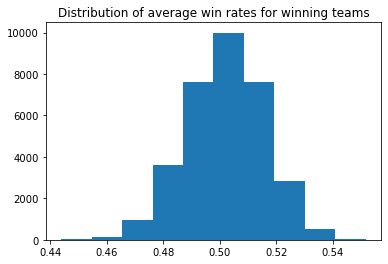

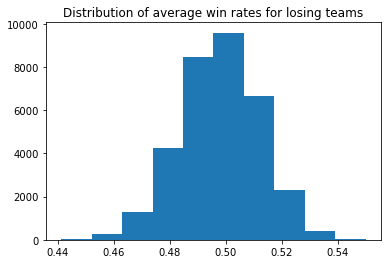

1.0567186150410408


Ttest_indResult(statistic=37.57878608945168, pvalue=7.713901608759776e-306)

In [14]:
# we randomly separate the matches into two categories
indices = [i for i in data.index]
# shuffle the indices to split into two categories
random.shuffle(indices)
# get two samples
ind1 = indices[:len(data)//2]
ind2 = indices[len(data)//2:]
t1 = [data.loc[i,'winning_win_rate'] for i in ind1]
t2 = [data.loc[i,'losing_win_rate'] for i in ind2]
# check for normality
plt.hist(t1)
plt.title('Distribution of average win rates for winning teams')
plt.show()
plt.hist(t2)
plt.title('Distribution of average win rates for losing teams')
plt.show()
# based on the graphs below, we can assume normality for the data samples
# check if two samples have equal variance
larger = max(np.var(t1), np.var(t2))
smaller = min(np.var(t1), np.var(t2))
print(larger/smaller)
# since ratio of the variances are less than 4, we assume that the samples have equal variance
# now we perform the test to check if are equal
st.ttest_ind(t1, t2, equal_var=True)

Based on the test above, we see that the p-value is approximately 0, indicating that there is strong evidence that the win rate between winning and losing teams are different. Therefore, we can utilize this metric to use in our model in our next step. <br>
Also, we can take it a step further, and also analyze the relations between characters on opposing teams. We know that for some characters, there exists strong counter-matchups, which would be bad against some other characters. For example, say god A has a low winrate against god B, but has a high winrate against god C, and the average win rate for B and C are the same across all games. Therefore, in a matchup between A and B, we would expect A to have the same probability of winning as against C, since B and C have the same winrate. However, with the added information of A having a higher winrate against C, as compared to B, we would change our prediction to expect A to have a higher probability of winning against C than against B. We will explore this concept below, and try to develop an aggregated team metric of how strong of a team does against individual characters on the opposing teams. 

Lets first develop a dataframe that stores the winrate of every god against every other god. We will also store the number of times those gods played to measure the significance of the relationship.

In [15]:
nextIndex = 0
godIndexer = {}
indexToGod = {}
godMatchups = np.zeros((116,116))
for i, row in data.iterrows():
    winners = row.winningGods.split(',')[:-1]
    losers = row.losingGods.split(',')[:-1]
    for winner in winners:
        for loser in losers:
            if not winner in godIndexer:
                godIndexer[winner] = nextIndex
                indexToGod[nextIndex] = winner
                nextIndex += 1
            if not loser in godIndexer:
                godIndexer[loser] = nextIndex
                indexToGod[nextIndex] = loser
                nextIndex += 1
            godMatchups[godIndexer[winner]][godIndexer[loser]] += 1
            
column_names = ["winner", "loser", "winrate", "timesplayed"]
matchupdata = pd.DataFrame(columns = column_names)

for winnerIndex, arr in enumerate(godMatchups):
    for loserIndex, wins in enumerate(arr):
        timesplayed = wins + godMatchups[loserIndex][winnerIndex]
        winrate = (100. * wins)/(wins + godMatchups[loserIndex][winnerIndex])
        matchupdata = matchupdata.append({"winner" : indexToGod[winnerIndex], 
                                          "loser" : indexToGod[loserIndex], 
                                          "winrate" : winrate, 
                                          "timesplayed" : timesplayed}, ignore_index = True)


<ipython-input-15-2b8c773b394f>:26: RuntimeWarning: invalid value encountered in double_scalars
  winrate = (100. * wins)/(wins + godMatchups[loserIndex][winnerIndex])


You may encounter an invalid value warning here. It is relatively easy to fix as it is a divide by zero error. This is because gods cannot play a match against themselves so they end up with a "nan" value as a winrate against themselves. It doesn't affect our analysis though.

In [16]:
# remove columns, where the same character is in 
matchupdata = matchupdata[matchupdata['timesplayed'] != 0.0]
matchupdata

,winner,loser,winrate,timesplayed
1,Apollo,Susano,57.954545,264.0
2,Apollo,Terra,55.102041,196.0
3,Apollo,Olorun,44.237918,269.0
4,Apollo,Ullr,51.776650,394.0
5,Apollo,Xing Tian,50.148368,337.0
...,...,...,...,...
13450,Cliodhna,Bakasura,50.704225,71.0
13451,Cliodhna,Nemesis,55.128205,234.0
13452,Cliodhna,Hera,52.475248,101.0
13453,Cliodhna,Jing Wei,56.521739,138.0


Above, we have created a DataFrame displaying a simple graph, showing the winrate between two gods, and the number of times played. For our metric in determining how well a team does against the opposing team, we can iterate through team A's gods, and retrieve the winrate against each god on team B, and average it. However, we must also take into consideration the number of games played between every two pairs, since some pairs are played more often than others, so pairs that are played often, we are more confident in, since we have more data, and less confident in pairs that have played few games. Therefore, we can also add weights by putting less emphasis on pairs that have played few games, and more weight on pairs that have played a large number of games against each other. 
<br>
To reiterate, the metric we will be calculating is the counter-matchup metric, which will be a value between 0 to 1, with a higher value indicating the team has won more times against individual characters on the opposing team. Also, we will be calculating the counter-matchup metric in respects from the winning side. Therefore, to get the counter-matchup for the losing side, with 1 - counter_matchup_winning_side.

In [17]:
matchup_pairs = {}
for i,row in matchupdata.iterrows():
    if row.winner not in matchup_pairs:
        matchup_pairs[row.winner] = {}
    if row.loser not in matchup_pairs[row.winner]:
        matchup_pairs[row.winner][row.loser] = {'winrate':row.winrate, 'timesplayed':row.timesplayed}


In [18]:
counter_matchup = []

for i,row in data.iterrows():
    match = row.matchId
    # gather teams from secondary table
    winners = row.winningGods.split(',')[:-1]
    losers = row.losingGods.split(',')[:-1]
    winrates = []
    weights = []
    # find weights and winrates between all possible pairs (25)
    for god1 in winners:
        for god2 in losers:
            pair = matchup_pairs[god1][god2]
            weights.append(pair['timesplayed'])
            winrates.append(pair['winrate'])
    # calculate the weighted counter-matchup metric
    val = 0
    total_weight = sum(weights)
    for index in range(len(weights)): 
        val += (winrates[index])*(weights[index]/total_weight)
        
    counter_matchup.append(val)
    
data['counter'] = counter_matchup

In [19]:
data

,matchId,region,matchLength,winningGods,losingGods,averageRank,winnerStructureDamage,loserStructureDamage,goldDisparity,rank_interval,rank,winning_win_rate,losing_win_rate,counter
0,1202691204,EU,1617,"Apollo,Tyr,Medusa,Tiamat,Cabrakan,","Susano,Terra,Olorun,Ullr,Xing Tian,",1645.707922,9763,275,15926,"[1525, 2000)",Platinum,0.484474,0.497682,49.207480
1,1202691205,EU,1804,"Charybdis,Ravana,Agni,Sylvanus,Khepri,","Sol,Tsukuyomi,Izanami,Olorun,Athena,",1121.244445,14442,3793,13166,"[640, 1205)",Silver,0.495205,0.529717,46.950732
2,1202691206,Brazil,1207,"Charybdis,Janus,Nike,Chang'e,Athena,","Loki,Zeus,Achilles,Poseidon,Hachiman,",2136.131809,7725,1062,16310,"[2000, 2500)",Diamond,0.485695,0.505884,48.305205
3,1202691207,Brazil,1101,"Hun Batz,Ullr,Achilles,Sol,Ares,","Anubis,Thanatos,Nike,Hou Yi,Kuzenbo,",1576.251272,5656,921,7859,"[1525, 2000)",Platinum,0.500717,0.501504,49.947890
4,1202691208,Brazil,2136,"Loki,Agni,Erlang Shen,Hou Yi,Kuzenbo,","Mercury,Neith,Ares,He Bo,Sun Wukong,",1524.409769,16217,471,15531,"[1205, 1525)",Gold,0.499410,0.492150,50.852923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69149,1208475349,NA,2226,"Scylla,Kali,Hou Yi,Nike,Cabrakan,","Loki,Chiron,Vamana,Chang'e,Khepri,",1395.400953,7585,13784,-305,"[1205, 1525)",Gold,0.518207,0.521339,49.257850
69150,1208475350,NA,1720,"Hun Batz,Rama,Morgan Le Fay,Cerberus,Serqet,","Fenrir,Odin,Sol,Baba Yaga,Cliodhna,",2155.130089,10141,4510,15690,"[2000, 2500)",Diamond,0.472304,0.513577,46.155878
69151,1208475351,NA,660,"Sol,Gilgamesh,Artio,Nike,Ah Muzen Cab,","Apollo,Pele,Ganesha,Chang'e,Neith,",1060.898503,3044,111,6103,"[640, 1205)",Silver,0.532543,0.499065,52.657511
69152,1208475354,NA,1392,"Loki,Sol,Mulan,Hou Yi,Khepri,","Medusa,Erlang Shen,Tsukuyomi,Tiamat,Sylvanus,",2058.574822,8403,753,7576,"[2000, 2500)",Diamond,0.525656,0.488489,53.288652


### 3.3 Kills and Wins

This next data analysis is just something we were curious about.

One potentially interesting set of statistics would be to see which gods tend to require kills and damage to be effective to their team, and which didn't. Two different types of gods in SMITE are assassins, who primarily focus on killing the enenmies by surprise but aren't very helpful in large team fights, and guardians, who tend to support the team and not get as involved in doing damage. We hypothesize that we should see that assassins tend to only win when getting high numbers of kills, where guardians tend to win without a large number of kills.

In [20]:
print(f'The average winning player has {playerdata[playerdata["winner"] == 1]["kills"].mean()} kills')
print(f'The average losing player has {playerdata[playerdata["winner"] == 0]["kills"].mean()} kills')
print(f'The average winning player has {playerdata[playerdata["winner"] == 1]["deaths"].mean()} deaths')
print(f'The average losing player has {playerdata[playerdata["winner"] == 0]["deaths"].mean()} deaths')

The average winning player has 6.270208871016146 kills
The average losing player has 3.9480373326931155 kills
The average winning player has 3.980664425904808 deaths
The average losing player has 6.290381729788128 deaths


So it clearly is true that winning players tend to have more kills. It also makes sense that the death numbers are just slightly larger than the other side's kill numbers. In SMITE, there is no way to kill someone without them receiving a death, however if a player dies to an NPC (rare) a kill is not awarded. So we would expect slightly fewer kills for the winners than the losers have deaths and vice versa.

Now we break the data down by team and look at the difference in total kills. We can view the percentage of winning teams at each deficit.

<BarContainer object of 80 artists>

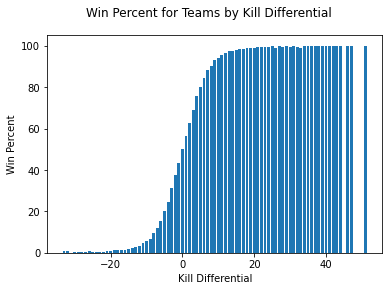

In [21]:
# lets set all kills by losing players to negative, then group entries by matchid to find the kill differential for each match
playerdatamod = playerdata.copy()
playerdatamod['kills'] = playerdatamod['kills'].where(playerdatamod['winner'] == 1,playerdatamod['kills'] * -1)
killdifferences = playerdatamod.groupby('matchId').sum()
killdifferences

fig, ax = plt.subplots()
x = []
y = []
counts = killdifferences['kills'].value_counts()
for k,v in counts.iteritems():
    # now lets calculate the percentage of winning teams at every represented kill differential
    x.append(k)
    # since losing teams have the inverse amount of kill differential, we look up k * -1
    if counts.get(k * -1):
        p = v / (v + counts.get(k * -1)) * 100
    else:
        p = 100
    y.append(p)

fig.suptitle('Win Percent for Teams by Kill Differential')
plt.xlabel('Kill Differential')
plt.ylabel('Win Percent')
plt.bar(x,y)

So these results are interesting but expected. We once again see that at negative kill differentials there are a very low percentage of teams who win, but at anything above a kill difference of 10 it's almost a guarentee that the team that won had more kills.

But how do different god types affect these measurements?

In [22]:
# define sets of all the god classes assassin, guardian, hunter, mage, and warrior
assassins = {'Arachne','Awilix','Bakasura','Bastet','Camazotz','Cliodhna','Da Ji','Fenrir','Hun Batz','Kali','Loki',
             'Mercury','Ne Zha','Nemesis','Pele','Ratatoskr','Ravana','Serqet','Set','Susano','Thanatos','Thor',
             'Tsukuyomi'}
guardians = {'Ares','Artio','Athena','Atlas','Bacchus','Cabrakan','Cerberus','Cthulhu','Fafnir','Ganesha','Geb',
             'Jormungandr','Khepri','Kumbhakarna','Kuzenbo','Sobek','Sylvanus','Terra','Xing Tian','Yemoja','Ymir'}
hunters = {'Ah Muzen Cab','Anhur','Apollo','Artemis','Cernunnos','Charybdis','Chernobog','Chiron','Cupid','Danzaburou',
           'Hachiman','Heimdallr','Hou Yi','Izanami','Jing Wei','Medusa','Neith','Rama','Skadi','Ullr','Xbalanque'}
mages = {'Agni','Ah Puch','Anubis','Ao Kuang','Aphrodite','Baba Yaga','Baron Samedi','Chang\'e','Chronos','Discordia',
         'Eset','Freya','Hades','He Bo','Hel','Hera','Janus','Kukulkan','Merlin','Morgan Le Fay','Nox','Nu Wa','Olorun',
         'Persephone','Poseidon','Ra','Raiji','Scylla','Sol','The Morrigan','Thoth','Tiamat','Vulcan','Zeus','Zhong Kui'}
warriors = {'Achilles','Amaterasu','Bellona','Chaac','Cu Chulainn','Erlang Shen','Gilgamesh','Guan Yu','Hercules','Horus',
            'King Arthur','Mulan','Nike','Odin','Osiris','Sun Wukong','Tyr','Vamana'}

playerdataassassins = playerdata[playerdata['god'].isin(assassins)]
playerdataguardians = playerdata[playerdata['god'].isin(guardians)]
playerdatahunters = playerdata[playerdata['god'].isin(hunters)]
playerdatamages = playerdata[playerdata['god'].isin(mages)]
playerdatawarriors = playerdata[playerdata['god'].isin(warriors)]

# make a function that keeps track of win percentage for any given number of kills and plots it
# we'll use stat rather than just kills to make this generalizable for deaths, assists, or player damage
def getwinpercents(godset, stat):
    # slice dataframe to get proper set
    df = playerdata[playerdata['god'].isin(godset)]
    
    # default dictionary is essentially just a dictionary with a get that
    # returns the output of the lambda for nonexistant keys
    winpercents = defaultdict(lambda : (0,0))
    for i, row in df.iterrows():
        wins, games = winpercents[row[stat]]
        if row.winner == 1:
            wins += 1
        winpercents[row[stat]] = (wins, games + 1)
    return winpercents

winpercentassassins = getwinpercents(assassins, 'kills')
winpercentguardians = getwinpercents(guardians, 'kills')
winpercenthunters = getwinpercents(hunters, 'kills')
winpercentmages = getwinpercents(mages, 'kills')
winpercentwarriors = getwinpercents(warriors, 'kills')

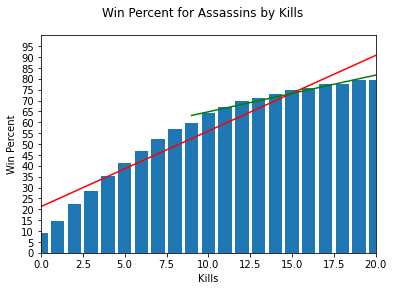

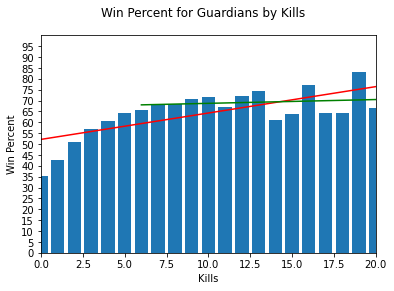

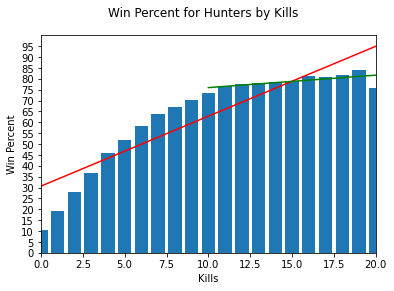

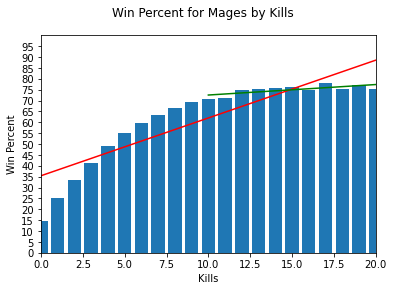

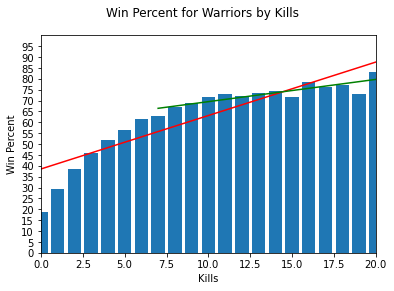

In [23]:
def plotwinpercents(winpercents, godtype, stat):
    platpercent = 3
    fig, ax = plt.subplots()
    x = []
    y = []
    xplat = []
    yplat = []
    last = -10
    plat = False
    for kills, (wins, games) in sorted(winpercents.items()):
        if kills <= 20:
            winpercent = wins/games * 100
            if winpercent < last + platpercent:
                plat = True
            if plat:
                xplat.append(kills)
                yplat.append(winpercent)
            else:
                last = winpercent
            x.append(kills)
            y.append(winpercent)
            
    fig.suptitle(f'Win Percent for {godtype} by {stat}')
    plt.xlabel(f'{stat}')
    plt.ylabel('Win Percent')
    plt.xlim([0, 20])
    plt.ylim([0, 100])
    plt.yticks(np.arange(0, 100, 5))
    m, b = np.polyfit(x, y, 1)
    x = np.array(x)
    ax.plot(x, m * x + b,'r')
    m, b = np.polyfit(xplat, yplat, 1)
    xplat = np.array(xplat)
    ax.plot(xplat, m * xplat + b,'g')
    plt.bar(x,y)
    
plotwinpercents(winpercentassassins, 'Assassins', 'Kills')
plotwinpercents(winpercentguardians, 'Guardians', 'Kills')
plotwinpercents(winpercenthunters, 'Hunters', 'Kills')
plotwinpercents(winpercentmages, 'Mages', 'Kills')
plotwinpercents(winpercentwarriors, 'Warriors', 'Kills')

These are some really cool results. We can see that for an assassin, if they can't get many kills, they're toast. They also have the steepest regression line. Guardians are not only the only class where there's not clearly a consistent upward trend, they have the least steep regression line. One thing we did is throw out values where the number of kills was > 20. That's because that is so extraordinarily rare that we barely had data, and at almost every value the winrate was 100% or 0% because there was only one datapoint.

Another thing we added was we checked for when the data started to plateau to check for diminishing returns. We checked for this by checking for the first time the winrate increased by less than 3 percent, a value we tinkered with until it made sense. We can see most classes tend to get about a 75% winrate once they get enough kills, and more kills doesn't really help too much more. Once again, assassins stand out for still having increasing winrate up to 80% winrate, showing how important kills are to their game. They don't get diminishing returns as badly on kills. Also, we see that warriors and guardians plateau earlier than the other classes, which makes sense as warriors, along with guardians, tend to be more utility focused, and thus kills don't have as much impact beyond a certain point.

## 4. Model
Now that we have a better understanding about the data from the above step, we can now continue to develop a general predictive model to determine which team is more favored to win, given a matchup.
<br>
For our model, we will create a logistic regression model, since a logistic model always generates a value between 0 and 1, making it a good model for binary classification, in our case.

In [24]:
# we randomly separate the matches into two categories
indices = [i for i in data.index]
# shuffle the indices to split into two categories
random.shuffle(indices)
# get two samples
ind1 = indices[:len(data)//2]
ind2 = indices[len(data)//2:]
t1 = [data.loc[i,'winning_win_rate'] - data.loc[i,'losing_win_rate'] for i in ind1]
t2 = [data.loc[i,'losing_win_rate'] - data.loc[i,'winning_win_rate'] for i in ind2]

# properly set up attributes in x and y
wins = t1 + t2
x = [[wins[i]] for i in range(len(wins))]
y = [1]*len(ind1) + [0]*len(ind2)

In [25]:

# split the dataset into testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
# create and train the model
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
# print coefficients
print('coefficients and intercept: ', end='')
print(logreg.coef_, logreg.intercept_)
# check accuracy with testing set
y_pred=logreg.predict(x_test)
# now we look at how well our model performed, with accuracy, precision, and recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#print("Precision:",metrics.precision_score(y_test, y_pred))
#print("Recall:",metrics.recall_score(y_test, y_pred))

coefficients and intercept: [[16.52889503]] [0.0073264]
Accuracy: 0.5781165596302743


As we see above, by using only our first metric, of the difference between the average win rate between the two teams, we are only able to achieve an accuracy of 0.581. Also, since we randomly shuffled the dataset to split into training and testing sets, your coefficients, intercept, and accuracy values might differ.
We can test for other metrics, such as precision and recall, but for simplicity, we will mainly focus on accuracy. Here is a link to an article for those interested in understanding the other metrics for measuring the performance of your model: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

<br>
While it's good that we have achieved a higher accuracy than pure guessing of an expected 0.50, our model is not as accurate as we would like it to be. Therefore, we can add more metrics to consider, such as taking into account not only the team's average win rate individually, but also take into account the win rate against the characters on the opposing team, to see if we can improve our current model. 

In [26]:
# gather data from 'counter' column
c1 = [data.loc[i,'counter'] for i in ind1]
c2 = [100-data.loc[i,'counter'] for i in ind2]
# properly set up attributes in x and y
counters = c1 + c2
x = [[wins[i],counters[i]] for i in range(len(wins))]

In [27]:
# split the dataset into testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.75,random_state=0)
# create and train the model
logreg1 = LogisticRegression()
logreg1.fit(x_train,y_train)
# print coefficients
print('coefficients and intercept: ', end='')
print(logreg1.coef_, logreg1.intercept_)
# check accuracy with testing set
y_pred = logreg1.predict(x_test)
# look at how well model performed
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#print("Precision:",metrics.precision_score(y_test, y_pred))
#print("Recall:",metrics.recall_score(y_test, y_pred))

coefficients and intercept: [[-1.98552682  0.23998235]] [-11.99186312]
Accuracy: 0.5932617089810536


As we see, our new logistic regression model, using both metrics, achieves a higher accuracy than our previous model. However, as we see, our accuracy for our new model is approximately 0.590, which is only 0.09 off from randomly guessing.

This can be explained by the fact that in the data explaratory section, we see that the vast majority of characters had average win rates relatively close to each other. This in of itself showed that it might be difficult to determine which team might win purely off of drafts alone. However, being able to achieve a 0.590 accuracy is still a small victory, in bringing some insight into pre-game analysis of the drafts and historical insight into the matchups, while most models using post game data, will most likely achieve a higher accuracy, due to more attributes to analyze, as compared to our models, which we limited to only pre-game information, such as team drafts.

### Potential Alternatives
It's worth mentioning that we also tried using decision trees, random forest, and svm classifiers to try to predict the winners. However, these seemed to be only about as good as random guessing. The svm was promising, and started to get pretty decent at it, but ultimately took too long to train for the purposes of this project. In the future, we would try to optimize an svm model and see if it could outperform our logistic regressions.

## 5. Conclusion

For this project, we aimed to determine if it's possible to generate a model to predict which team would win given their drafts. The vast majority of models for match predictions take into account in game action, such as number of objectives taken by a team, and gold differences between teams. For our models, we aimed to determine if it's possible to develop a model to predict which team will win based purely off of the gods selected.
<br>

Within our data exploratory section, we got to better understand the dataset. We took a look at the distribution of games across ranks, the most played gods, potential countermatchups, and how important kills are to one's game based on what class of god they choose to play.
<br>

We were able to derive some metrics of interst, such the average win rate of a team, and the average counter-matchup rate of a team, calculated by averaging and weighing the winrates of pairs of characters against one another. 
<br>

From there, we explored possible models, such as logistic regression models to predict which team is most likely to win. We developed two separate models, one using only the average win rate between a team, and another model using both the average win rate between a team, and the counter matchup win rate between characters on opposing teams. We were able to achieve a higher accuracy with the second model, but only roughly a 0.600 accuracy at best. Going into developing the model using purely pre-game data, such as the drafts, we understood that it might be impossible to create a model for predicting match outcome. This is due to the fact that the outcome of a game is so dependent on what happens during the match. However, we were curious to see how accurate a model purely trained on pre-game data could get. We believe the model is a relative success and further analysis and tinkering can possibly achieve higher accuracy. Based on the work above, we beleive that while understanding drafts can be good in having a vague idea on which team could win, the vast majority comes down to team play and in game action.